In [1]:
import keras
import matplotlib.pyplot as plt
from IPython.display import clear_output

class PlotLosses(keras.callbacks.Callback):
    def __init__(self, plot_interval=1, evaluate_interval=10, x_val=None, y_val_categorical=None):
        self.plot_interval = plot_interval
        self.evaluate_interval = evaluate_interval
        self.x_val = x_val
        self.y_val_categorical = y_val_categorical
        #self.model = model
    
    def on_train_begin(self, logs={}):
        print('Begin training')
        self.i = 0
        self.x = []
        self.losses = []
        self.val_losses = []
        self.acc = []
        self.val_acc = []
        self.logs = []
    
    def on_epoch_end(self, epoch, logs={}):
        if self.evaluate_interval is None:
            self.logs.append(logs)
            self.x.append(self.i)
            self.losses.append(logs.get('loss'))
            self.val_losses.append(logs.get('val_loss'))
            self.acc.append(logs.get('acc'))
            self.val_acc.append(logs.get('val_acc'))
            self.i += 1
        
        if (epoch%self.plot_interval==0):
            clear_output(wait=True)
            f, (ax1, ax2) = plt.subplots(1, 2, sharex=True, figsize=(20,5))
            ax1.plot(self.x, self.losses, label="loss")
            ax1.plot(self.x, self.val_losses, label="val_loss")
            ax1.legend()

            ax2.plot(self.x, self.acc, label="acc")
            ax2.plot(self.x, self.val_acc, label="val_acc")
            ax2.legend()
            plt.show();
        #score = self.model.evaluate(x_test, y_test_categorical, verbose=0)
        
        #print("accuracy: ", score[1])
    
    def on_batch_end(self, batch, logs={}):
        if self.evaluate_interval is not None:
            if (batch%self.evaluate_interval==0):
                self.i += 1
                self.logs.append(logs)
                self.x.append(self.i)
                self.losses.append(logs.get('loss'))
                self.acc.append(logs.get('acc'))

                if self.x_val is not None:
                    score = self.model.evaluate(self.x_val, self.y_val_categorical, verbose=0)
                    self.val_losses.append(score[0])
                    self.val_acc.append(score[1])

Using TensorFlow backend.
C:\ProgramData\Anaconda3\envs\tensorflow\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
import numpy as np
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical

In [3]:
folder = './data/'
x = np.load(folder+'train_images.npy')
y = np.loadtxt(folder+'train_labels.csv', delimiter=',', skiprows=1)
x_test = np.load(folder+'test_images.npy')

In [4]:
x_train, x_valid, y_train, y_valid = train_test_split(x, y, test_size = 0.1)

y_train_categorical = to_categorical(y_train)
y_val_categorical = to_categorical(y_valid)

x_train_final = x_train.reshape(-1, 28, 28, 1)
x_valid_final = x_valid.reshape(-1, 28, 28, 1)
x_test_final = x_test.reshape(-1, 28, 28, 1)

print(x_train_final.shape)
print(x_valid_final.shape)
print(x_test_final.shape)

(54000, 28, 28, 1)
(6000, 28, 28, 1)
(10000, 28, 28, 1)


In [5]:
from keras.callbacks import ModelCheckpoint 
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D, InputLayer
from keras.layers.normalization import BatchNormalization
from keras import optimizers
from keras import initializers
from keras import regularizers

In [6]:
prob_cn = 0.1
prob_fc = 0.5

model=Sequential()

model.add(InputLayer(input_shape=(28,28,1),name='Input'))
model.add(BatchNormalization())

#convolutional model

model.add(Conv2D(filters=64, kernel_size=(3, 3), padding="same", name='Conv1'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2), name='MaxPool1'))
model.add(Dropout(prob_cn))

model.add(Conv2D(filters=64, kernel_size=(3, 3), padding="same", name='Conv2'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2), name='MaxPool2'))
model.add(Dropout(prob_cn))

model.add(Flatten())

#fully connected model

model.add(Dense(512))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(prob_fc))

model.add(Dense(256))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(prob_fc))

model.add(Dense(10, activation='softmax'))

model.summary()

Instructions for updating:
keep_dims is deprecated, use keepdims instead
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input (InputLayer)           (None, 28, 28, 1)         0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 28, 28, 1)         4         
_________________________________________________________________
Conv1 (Conv2D)               (None, 28, 28, 64)        640       
_________________________________________________________________
activation_1 (Activation)    (None, 28, 28, 64)        0         
_________________________________________________________________
MaxPool1 (MaxPooling2D)      (None, 14, 14, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 14, 14, 64)        0         
_________________________________________________________________
Con

In [7]:
# Compilo el modelo
lr = 0.001
optimizer = optimizers.adam(lr=lr)
model.compile(loss = 'categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

Instructions for updating:
keep_dims is deprecated, use keepdims instead
Instructions for updating:
keep_dims is deprecated, use keepdims instead


In [8]:
# Callbacks
## Callback para graficar
plot_losses = PlotLosses(plot_interval=1, evaluate_interval=50, x_val=x_valid_final, y_val_categorical=y_val_categorical)
## Callback para guardar pesos
checkpointer = ModelCheckpoint(filepath='single-layer.mnist.hdf5', verbose=1, save_best_only=True)

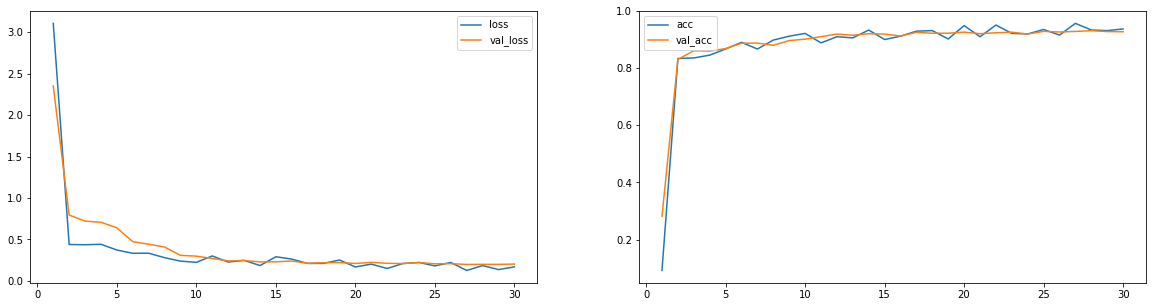

Epoch 00009: val_loss improved from 0.19989 to 0.19585, saving model to single-layer.mnist.hdf5
54000/54000 [==============================] - 160s - loss: 0.1672 - acc: 0.9380 - val_loss: 0.1958 - val_acc: 0.9308


In [9]:
batch_size = 512
model.fit(x_train_final, 
          y_train_categorical,
          epochs=10, batch_size=batch_size, 
          verbose=1, 
          validation_data = (x_valid_final, y_val_categorical),
          callbacks=[plot_losses, checkpointer],
         )


In [10]:
loss, acc = model.evaluate(x_valid_final, y_val_categorical)

5984/6000 [============================>.] - ETA: 0s

In [11]:
print(acc)
#0.9308333333333333

0.9308333333333333


In [12]:
test_prediction = model.predict(x_test_final)
test_labels = np.argmax(test_prediction, axis = 1)

In [13]:
import pandas
df = pandas.DataFrame(data={"Category": test_labels}).astype(int)
df.to_csv("./submission_jnf_val_acc_0_9308.csv", sep=',',index=True,  index_label='Id')

In [14]:
# TEST ACC: 